Przetwarzanie danych złożonych - lab 1 - proces Hawkesa  
W oparciu o dowolny zbiór danych:

- analiza zbioru i uzasadnienie dlaczego nadaje się do modelowania procesem Hawkesa (2pkt)
- wybór odpowiedniego procesu Hawkesa/krenela do danych i dopasowanie parametrów dla dwóch kaskad (4pkt)
- porównanie dynamiki dwóch kaskad na podstawie parametrów procesu Hawkesa (2pkt)
- przewidzenie końcowego rozmiaru kaskady (2pkt)


https://snap.stanford.edu/data/cit-HepTh.html  

Zbiór zawiera graf cytowań co jest klasycznym przypadkiem pod procesy Hawksa, gdyż, potencjalnie, często cytowane prace mogą być jeszcze bardziej cytowane w przyszłości.  
Zbiór zawiera informacje o czasie publikacji, więc można analizować w tym kontekście.

In [1]:
if (!require('devtools')) install.packages('devtools')
devtools::install_github('behavioral-ds/evently')

library(evently)
setup_ampl("/root/ampl")

Loading required package: devtools

Loading required package: usethis

Skipping install of 'evently' from a github remote, the SHA1 (d3e6a693) has not changed since last install.
  Use `force = TRUE` to force installation

Warning message in unzip(zipfile = "/tmp/ipopt.zip", exdir = ampl_final_path):
“error 1 in extracting from zip file”


In [2]:
library(evently)
library(dplyr)



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




# Analiza

In [19]:
data <- read.csv('data.tsv',header=FALSE, sep='\t')
colnames(data) = c("SOURCE", "TARGET", "time")

# mutate(data, time= as.Date(time, format= "%Y-%m-%d"))
# df$time <- as.Date(data$time , format = "%Y-%m-%d")

# data["time"] <- lapply(data["time"], as.Date)
data$magnitude <- 1

Dla każdej pracy przypisujemy magnitude = 1

In [20]:
head(data)

,SOURCE,TARGET,time,magnitude
,<int>,<int>,<chr>,<dbl>
1,1001,9510225,1995-10-04,1
2,9511171,9510225,1995-10-04,1
3,9601108,9510225,1995-10-04,1
4,9602022,9510225,1995-10-04,1
5,9602114,9510225,1995-10-04,1
6,9603161,9510225,1995-10-04,1


In [21]:
as.numeric(difftime("2023-01-01","2022-01-01", units = "days"))

[1] 365

Grupujemy dane po tygodniu.

In [22]:
monnb <- function(d) { lt <- as.POSIXlt(as.Date(d, origin="1900-01-01")); 
                          lt$year*365 + lt$yday } 

mondf <- function(d1) { as.integer(as.numeric(difftime(d1,"1990-01-01", units = "weeks"))) }

data$time <- mondf(data$time)
data <- data[order(data$time, decreasing = FALSE),]
head(data)

,SOURCE,TARGET,time,magnitude
,<int>,<int>,<int>,<dbl>
20587,9402073,9310202,195,1
20588,9402031,9310202,195,1
20589,9709071,9310202,195,1
20590,9501070,9310202,195,1
20591,9501144,9310202,195,1
20592,9311012,9310202,195,1


Najpopularniejsze prace:

In [23]:
agg_df <- aggregate(data$magnitude, by=list(data$SOURCE), FUN=length)
agg_df <- agg_df[order(agg_df$x, decreasing = TRUE),]
head(agg_df)

,Group.1,x
,<int>,<int>
4966,111208,147
6807,207116,147
4476,109162,134
3657,106048,130
4572,110055,114
4272,108172,113


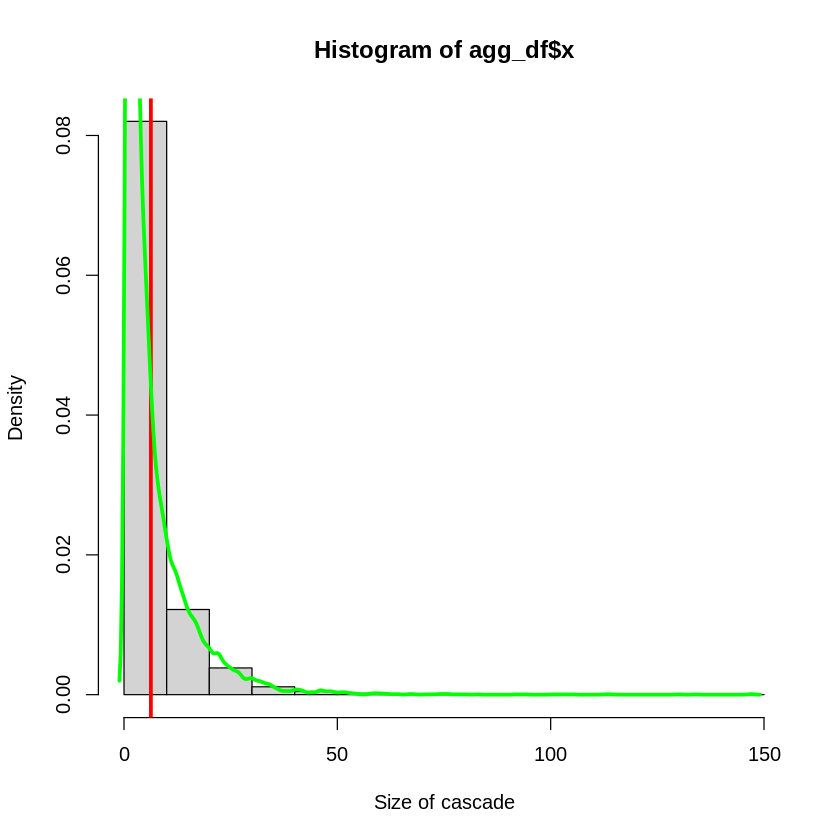

In [24]:
hist(agg_df$x, probability = TRUE, xlab='Size of cascade')
abline(v = mean(agg_df$x), col='red', lwd = 3)
lines(density(agg_df$x), col = 'green', lwd = 3)

Długość kaskady w tygodniach:

In [25]:
agg_df <- aggregate(data$time, by=list(data$SOURCE),  FUN = function(i)max(i) - min(i))
agg_df <- agg_df[order(agg_df$x, decreasing = TRUE),]
head(agg_df)

,Group.1,x
,<int>,<int>
5950,204004,441
6156,204234,440
6363,205200,440
6653,206196,440
6814,207124,440
7296,209145,440


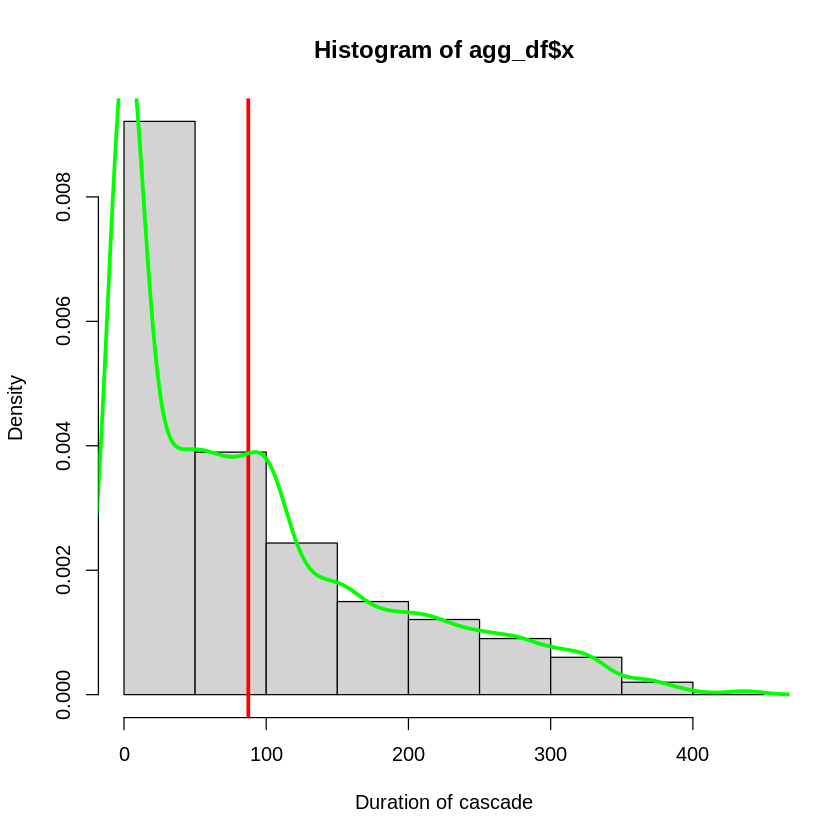

In [26]:
hist(agg_df$x, probability = TRUE, xlab='Duration of cascade')
abline(v = mean(agg_df$x), col='red', lwd = 3)
lines(density(agg_df$x), col = 'green', lwd = 3)

# Modelowanie

Tego typu rozpowszechnianie w sieci znane jest z właściwości eksponencjalnych.
Prosta funkcja EXP nie daje jednak oczekiwanych efektów w przeciwieństwie do Marked Hawkes - mEXP.

In [27]:

experiment <- function(data, article_id, train_split_time, model_type) {
    agg_df <- data[data$SOURCE==article_id,]
    # nie konieczne
    # agg_df %>% 
    #     group_by(time) %>% 
    #     summarise(magnitude = sum(magnitude))

    agg_df <- agg_df[order(agg_df$time, decreasing = FALSE),]
    actual_size <- sum(agg_df$magnitude)
    agg_df$time <- agg_df$time - min(agg_df$time)
 
    split_idx <- which(agg_df$time>=train_split_time, arr.ind=TRUE)[1]
    train_data <- agg_df[1:split_idx,]
  
    fitted_model <- fit_series(train_data, model_type = model_type, observation_time = 10, cores = 10)
    cat("Branching: ", get_branching_factor(fitted_model), '\n')
    prediction <- predict_final_popularity(fitted_model)
    cat("Training: ", sum(train_data$magnitude), " time: ", max(train_data$time) ,'\n')
    cat("Prediction: " , prediction, '\n')
    cat("Actual: " , actual_size, " time: ", max(agg_df$time) ,'\n')
    cat("Relative error: ", ((prediction - actual_size)/actual_size), '\n')
    return(fitted_model)
}

Jedna z bardziej popularnych prac:

Warning message in FUN(X[[i]], ...):
“The provided observation time is smaller than the last observed event! Attempt to slice the data.”


Branching:  1e-100 


Warning message in FUN(X[[i]], ...):
“The provided observation time is smaller than the last observed event! Attempt to slice the data.”


Training:  60  time:  221 
Prediction:  60 
Actual:  113  time:  248 
Relative error:  -0.4690265 
- Model: EXP 
- No. of cascades: 1 
- init_par:
  K 6.23e+00; theta 2.23e+00
- par:
  K 1.00e-100; theta 3.25e+01
- Neg Log Likelihood: 1e-100 
- lower_bound:
  K 1.00e-100; theta 1.00e-100
- upper_bound:
  K 1.00e+04; theta 3.00e+02
- Convergence: 0 


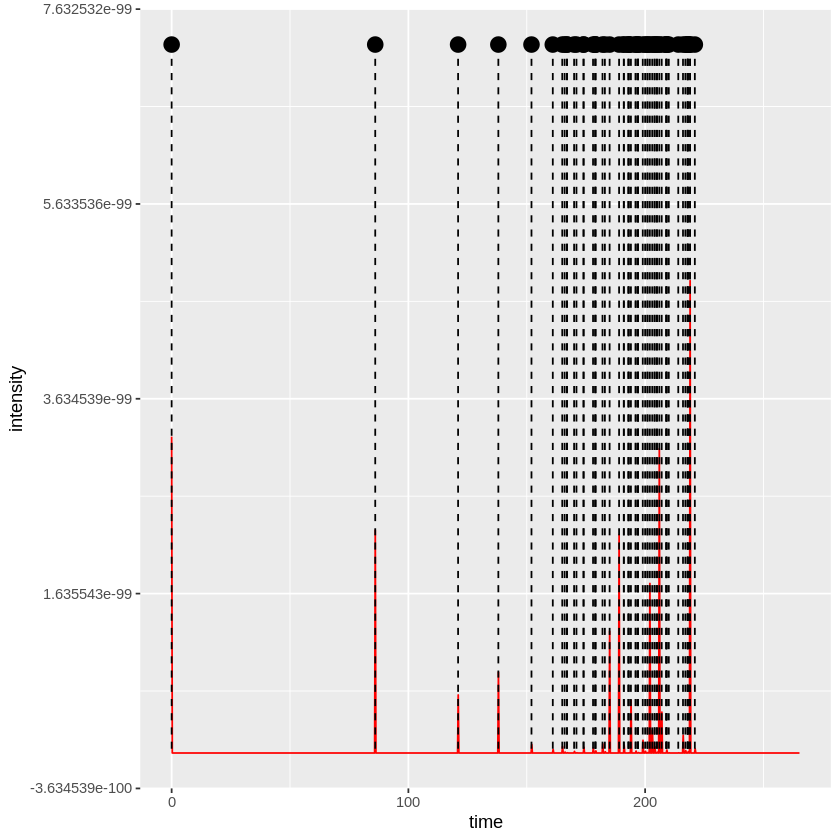

In [32]:
model <- experiment(data, 108172, 220, "EXP")
print(model)
plot_event_series(model)

Lepiej dopasowana funkcja

Warning message in FUN(X[[i]], ...):
“The provided observation time is smaller than the last observed event! Attempt to slice the data.”


Branching:  0.974353 


Warning message in FUN(X[[i]], ...):
“The provided observation time is smaller than the last observed event! Attempt to slice the data.”


Training:  60  time:  221 
Prediction:  97.0523 
Actual:  113  time:  248 
Relative error:  -0.1411301 
- Model: mEXP 
- No. of cascades: 1 
- init_par:
  K 3.67e+00; beta 8.79e-01; theta 7.68e-03
- par:
  K 9.50e-01; beta 2.51e-02; theta 1.00e-100
- Neg Log Likelihood: 0 
- lower_bound:
  K 1.00e-100; beta 1.00e-100; theta 1.00e-100
- upper_bound:
  K 1.00e+04; beta 1.02e+00; theta 3.00e+02
- Convergence: 0 


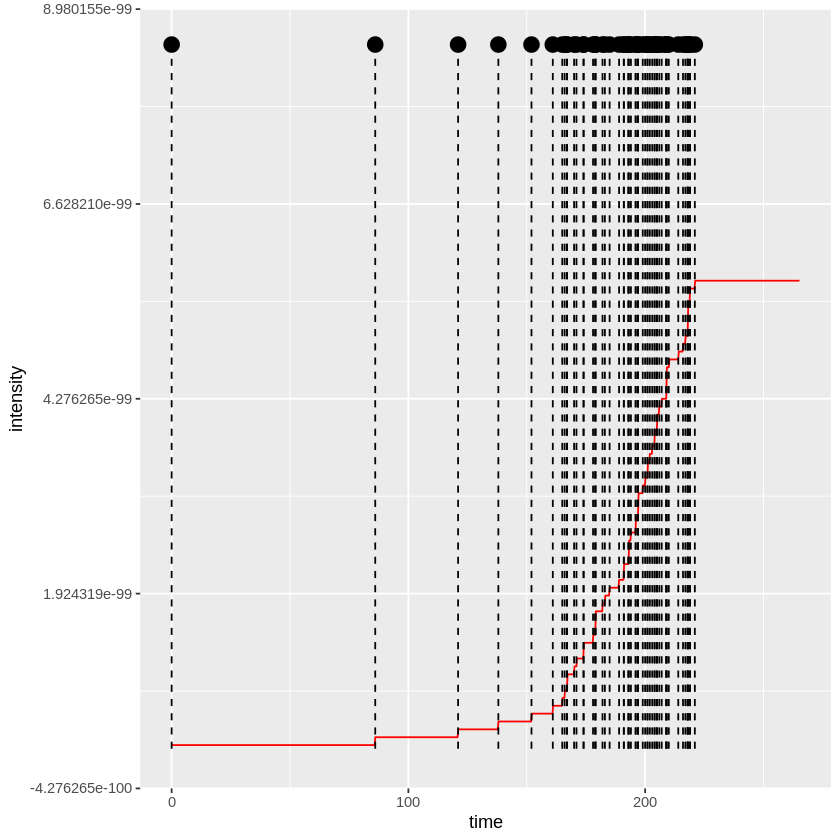

In [33]:
model <- experiment(data, 108172, 220, "mEXP")
print(model)
plot_event_series(model)

Jedna z dłuższych kaskad

Warning message in FUN(X[[i]], ...):
“The provided observation time is smaller than the last observed event! Attempt to slice the data.”


Branching:  0.974941 


Warning message in FUN(X[[i]], ...):
“The provided observation time is smaller than the last observed event! Attempt to slice the data.”


Training:  8  time:  353 
Prediction:  46.90582 
Actual:  27  time:  441 
Relative error:  0.7372527 
- Model: EXP 
- No. of cascades: 1 
- init_par:
  K 4.72e+00; theta 2.27e-01
- par:
  K 9.75e-01; theta 1.00e-100
- Neg Log Likelihood: 0 
- lower_bound:
  K 1.00e-100; theta 1.00e-100
- upper_bound:
  K 1.00e+04; theta 3.00e+02
- Convergence: 0 


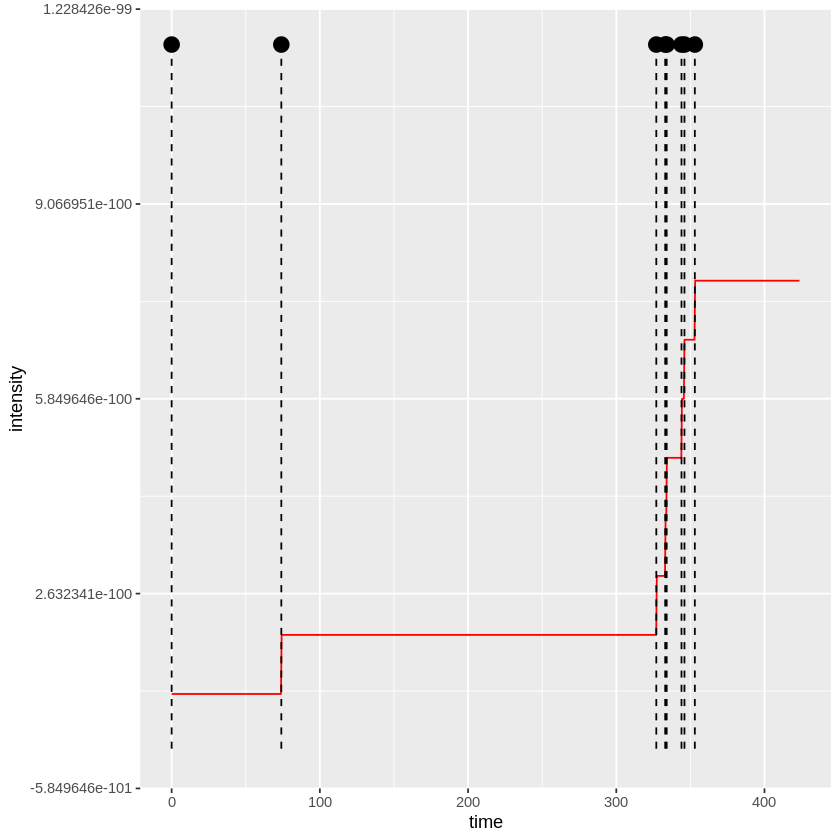

In [34]:
model <- experiment(data, 204004, 350, "EXP")
print(model)
plot_event_series(model)

Warning message in FUN(X[[i]], ...):
“The provided observation time is smaller than the last observed event! Attempt to slice the data.”


Branching:  0.9743459 


Warning message in FUN(X[[i]], ...):
“The provided observation time is smaller than the last observed event! Attempt to slice the data.”


Training:  8  time:  353 
Prediction:  45.09218 
Actual:  27  time:  441 
Relative error:  0.6700806 
- Model: mEXP 
- No. of cascades: 1 
- init_par:
  K 8.05e-01; beta 9.89e-02; theta 1.57e-02
- par:
  K 9.52e-01; beta 2.38e-02; theta 1.00e-100
- Neg Log Likelihood: 0 
- lower_bound:
  K 1.00e-100; beta 1.00e-100; theta 1.00e-100
- upper_bound:
  K 1.00e+04; beta 1.02e+00; theta 3.00e+02
- Convergence: 0 


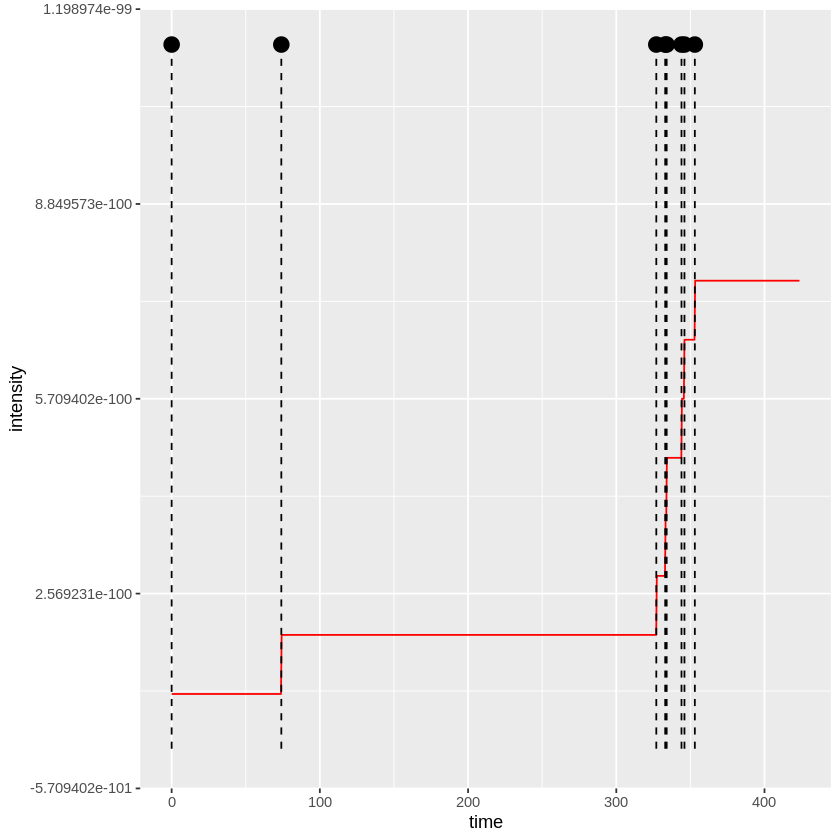

In [35]:
model <- experiment(data, 204004, 350, "mEXP")
print(model)
plot_event_series(model)